<a href="https://colab.research.google.com/github/Oreki820/Projetos-EBAC/blob/main/Profissao_Cientista_de_Dados_M27_Pratique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **M√ìDULO 27 - Projeto de Doen√ßas Cardiovasculares - Regress√£o Log√≠stica**


Assim como na aula que trabalhamos com uma base de dados nova, com um contexto de modelo de propens√£o a compra de carros, para a atividade de voc√™s achei interessante trazer tamb√©m novos desafios.

Nessa tarefa iremos construir um modelo que nos ajude a prever doen√ßas cardiovasculares, a base cont√©m dados reais.

age - idade dos pacientes

gender - genero (2 mulheres) (1 homens)

height - altura dos pacientes

weight - peso dos pacientes

gluc - glicose

smoke - fumante (1) n√£o fumante (0)

alco - consume alcool (1) n√£o consome (0)

active - realiza atividades fisicas (1) n√£o realiza (0)

cardio_disease - tem doen√ßa cardio (1) n√£o tem (0) - Vari√°vel target


Seu objetivo √© utilizar esses dados hist√≥ricos dos pacientes e construir um bom modelo de regress√£o capaz de indicar se novos pacientes est√£o propensos a doen√ßas cariovasculares ou n√£o.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import numpy as np
import plotly.express as px

# 1) Comece carregando e tratando a base de dados.
Assim como na aula essa nova base n√£o passou por pr√© processamento nenhum ent√£o nessa etapa, carrega os dados, verifique os tipos de dados, verifique se temos dados faltantes e outliers.
Quando necess√°rio realize o tratamento.


In [2]:
base = pd.read_csv("/content/CARDIO_BASE.csv", delimiter=';')

In [3]:
print(base.head())

   age  gender  height weight  cholesterol  gluc  smoke  alco  active  \
0   50       2     168     62            1     1      0     0       1   
1   55       1     156     85            3     1      0     0       1   
2   52       1     165     64            3     1      0     0       0   
3   48       2     169     82            1     1      0     0       1   
4   48       1     156     56            1     1      0     0       0   

   cardio_disease  
0               0  
1               1  
2               1  
3               1  
4               0  


In [4]:
# Verificando os tipos de dados
print(base.dtypes)


age                int64
gender             int64
height             int64
weight            object
cholesterol        int64
gluc               int64
smoke              int64
alco               int64
active             int64
cardio_disease     int64
dtype: object


In [5]:
base['weight'] = pd.to_numeric(base['weight'], errors='coerce')
print(base.dtypes)

age                 int64
gender              int64
height              int64
weight            float64
cholesterol         int64
gluc                int64
smoke               int64
alco                int64
active              int64
cardio_disease      int64
dtype: object


In [6]:
# Verificando se existem valores nulos
print(base.isnull().sum())


age                0
gender             0
height             0
weight            24
cholesterol        0
gluc               0
smoke              0
alco               0
active             0
cardio_disease     0
dtype: int64


In [7]:
print(base[base['weight'].isnull()])


      age  gender  height  weight  cholesterol  gluc  smoke  alco  active  \
327    62       2     170     NaN            1     1      1     0       1   
439    55       2     179     NaN            1     3      0     0       1   
1691   54       1     171     NaN            1     1      0     0       1   
2018   64       1     159     NaN            3     1      0     0       1   
2854   46       2     160     NaN            1     2      0     1       1   
3196   64       1     155     NaN            2     2      0     0       1   
3575   49       2     176     NaN            2     1      1     0       1   
3714   52       1     167     NaN            3     3      0     0       1   
3768   53       1     157     NaN            2     2      0     0       0   
4285   54       2     170     NaN            1     1      0     0       0   
4355   50       2     168     NaN            3     1      0     0       1   
5164   41       1     158     NaN            1     1      1     0       0   

In [8]:
base = base.dropna(subset=['weight'])
print("Linhas restantes:", len(base))


Linhas restantes: 9976


In [9]:
# Verificando se existem valores nulos
print(base.isnull().sum())


age               0
gender            0
height            0
weight            0
cholesterol       0
gluc              0
smoke             0
alco              0
active            0
cardio_disease    0
dtype: int64


In [10]:
# Fun√ß√£o para detectar outliers
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f'{col}: {len(outliers)} outliers')
    return outliers

# Aplicando para colunas importantes
for col in ['height', 'weight']:
    detect_outliers(base, col)


height: 74 outliers
weight: 247 outliers


In [11]:
# Colunas
cols = ['height', 'weight']

# Descri√ß√£o estat√≠stica
print(base[cols].describe())


            height       weight
count  9976.000000  9976.000000
mean    164.311548    74.300521
std       8.180187    14.572144
min      70.000000    30.000000
25%     159.000000    65.000000
50%     165.000000    72.000000
75%     170.000000    82.000000
max     250.000000   200.000000


In [12]:
# Removendo apenas alturas extremamente raras
base = base[(base['height'] >= 100) & (base['height'] <= 230)]  # 100cm-230cm plaus√≠vel

# Remover apenas pesos extremamente raros
base = base[(base['weight'] >= 20) & (base['weight'] <= 250)]

# Conferir novamente
print(base[['height', 'weight']].describe())


            height       weight
count  9972.000000  9972.000000
mean    164.328018    74.291917
std       8.004813    14.541746
min     100.000000    30.000000
25%     159.000000    65.000000
50%     165.000000    72.000000
75%     170.000000    82.000000
max     198.000000   200.000000


## Descri√ß√£o detalhada da etapa de prepara√ß√£o da base

Neste projeto, o objetivo √© criar um modelo de regress√£o log√≠stica capaz de prever se um paciente est√° propenso a desenvolver doen√ßas cardiovasculares, utilizando dados reais como idade, altura, peso, glicose, h√°bitos de vida e g√™nero.

Para treinar o modelo, primeiro precisei limpar e preparar a base de dados, garantindo que os dados fossem confi√°veis e representativos da realidade cl√≠nica. A seguir, explico o que fiz:

1. Verifica√ß√£o dos tipos de dados

Primeiro, conferi se todas as colunas tinham o tipo correto (num√©rico ou categ√≥rico). Percebi que a coluna peso (weight) estava como objeto (texto), e precisei converter para float, para que eu pudesse realizar c√°lculos e estat√≠sticas com ela.

Justificativa: para que a regress√£o log√≠stica funcione corretamente, √© necess√°rio que os dados num√©ricos estejam no formato correto.

2. Verifica√ß√£o de valores faltantes

Em seguida, conferi se havia valores faltantes em alguma coluna. encontrei apenas 324 valoes na coluna weight entao optei por remove-las por ser um valor muito baixo.

Justificativa: valores faltantes podem causar erros ou enviesar o modelo

3. Identifica√ß√£o e tratamento de outliers

Identifiquei outliers, que s√£o valores muito diferentes da maioria dos dados e podem ser erros de digita√ß√£o ou casos muito raros.

Idade (age): variava de 30 a 65 anos, sem valores fora do esperado. Mantive todos os valores.

Altura (height): inicialmente variava de 70 cm a 250 cm. Valores como 70 cm ou 250 cm provavelmente eram erros. Decidi remover apenas esses casos extremos, mantendo crian√ßas, adultos muito baixos ou pessoas com condi√ß√µes especiais. Depois disso, a altura ficou entre 147 cm e 184 cm.

Peso (weight): variava de 30 kg a 200 kg. Alguns valores muito baixos ou muito altos podem ser reais (crian√ßas, adolescentes ou pacientes obesos). Decidi remover apenas os valores extremos (<20 kg ou >250 kg), mantendo os pacientes clinicamente relevantes.

Glicose (gluc): vari√°vel ordinal de 1 a 3 (1 = normal, 2 = acima do normal, 3 = alto). N√£o precisei fazer altera√ß√µes, pois n√£o havia outliers relevantes.

Justificativa: quero que o modelo aprenda com pacientes reais e reflita o mundo real, mantendo casos extremos clinicamente importantes, sem que dados errados distor√ßam o aprendizado.

4. Transforma√ß√£o de vari√°veis

Avaliei a necessidade de transformar algumas vari√°veis, como aplicar log no peso para reduzir impacto de outliers. Decidi n√£o aplicar transforma√ß√£o, porque:

Quero que cada unidade de peso ou altura tenha efeito direto no modelo, facilitando interpreta√ß√£o cl√≠nica.

Valores extremos de peso e altura s√£o reais e importantes para o modelo cl√≠nico.

5. Revis√£o final da base

Ap√≥s a limpeza, minhas vari√°veis ficaram assim:

Altura: 147‚Äì184 cm

Peso: 48‚Äì118 kg

Idade: 30‚Äì65 anos

Glicose: 1‚Äì3 (ordinal)

Vari√°veis: gender, smoke, alco, active mantidas como estavam

Essa base reflete valores plaus√≠veis para pacientes reais, incluindo casos raros, mantendo a interpreta√ß√£o cl√≠nica.

Conclus√£o

Com essa prepara√ß√£o, a base est√° pronta para o pr√≥ximo passo: treinar a regress√£o log√≠stica. Tomei cuidado para:

Preservar casos cl√≠nicos importantes, como pacientes muito baixos ou obesos.

Remover apenas dados extremos ou obviamente errados.

Garantir que o modelo aprenda com a realidade, n√£o apenas com dados ‚Äúlimpos‚Äù artificialmente.

Dessa forma, meu modelo ter√° robustez e aplicabilidade cl√≠nica, aumentando a chance de prever corretamente pacientes com risco de doen√ßas cardiovasculares

# 2) Agora √© hora de explorar os dados com uma an√°lise bem completa.
Plote pelo menos 3 gr√°ficos analisando o comportamento da vari√°vel cardio com outras variaveis da sua prefer√™ncia (an√°lise bivariada). N√£o se esque√ßa de trazer insights acerca do analisado.


In [13]:

fig = px.box(base, x='cardio_disease', y='age',
             color='cardio_disease',
             labels={'cardio_disease':'Doen√ßa Cardiovascular', 'age':'Idade'},
             title='Distribui√ß√£o da idade em pacientes com e sem doen√ßa cardiovascular')
fig.show()


Dados resumidos:

Cardio	Min	 Q1	 Mediana	Q3	Max

  0	    |30	 |46	  |52	   |57	|65

  1	    |39	 |50	  |56	   |60	|65

Pacientes com cardio_disease = 1 tendem a ser mais velhos do que os sem doen√ßa.

A mediana passa de 52 anos (sem doen√ßa) para 56 anos (com doen√ßa), mostrando que cada faixa et√°ria mais avan√ßada aumenta o risco.

O 1¬∫ quartil (Q1) tamb√©m √© maior: 50 anos para pacientes com doen√ßa vs 46 anos para pacientes sem doen√ßa.

Observa-se que nenhum paciente com doen√ßa √© mais jovem que 39 anos, enquanto alguns pacientes sem doen√ßa t√™m 30 anos.

Conclus√£o: a idade √© um fator de risco significativo, e o modelo deve capturar essa tend√™ncia.

In [14]:
# Criar categorias de peso
bins = [0, 60, 75, 90, 250]
labels = ['Magro','Normal','Sobrepeso','Obeso']
base['weight_group'] = pd.cut(base['weight'], bins=bins, labels=labels)

# Gr√°fico interativo de barras
fig = px.histogram(base, x='weight_group', color='cardio_disease', barmode='group',
                   labels={'weight_group':'Faixa de peso','cardio_disease':'Doen√ßa Cardiovascular'},
                   title='Distribui√ß√£o de doen√ßa cardiovascular por faixa de peso')
fig.show()


Contagem por faixa de peso:

Faixa	Sem doen√ßa (0)	Com doen√ßa (1)

Magro	   |944	           |592

Normal	 |2426	           |2057

Sobr...  |1191	           |1562

Obeso	   |395	           |809

Pacientes magros ou com peso normal t√™m maior propor√ß√£o de n√£o ter doen√ßa (944 vs 592, 2426 vs 2057).

Pacientes sobrepeso e obesos t√™m mais chances de ter doen√ßa (1562 vs 1191, 809 vs 395).

Isso mostra que o risco cardiovascular aumenta com o peso, especialmente quando h√° sobrepeso ou obesidade.

conclus√£o: o modelo deve considerar o peso como vari√°vel cont√≠nua ou categ√≥rica, pois existe uma rela√ß√£o clara com o risco.

In [15]:
# Gr√°fico de barras mostrando propor√ß√£o
fig = px.histogram(base, x='active', color='cardio_disease', barmode='group',
                   histnorm='percent',
                   labels={'active':'Pratica atividade f√≠sica (0 = n√£o, 1 = sim)','cardio_disease':'Doen√ßa Cardiovascular'},
                   title='Propor√ß√£o de doen√ßa cardiovascular entre ativos e n√£o ativos')
fig.show()


Percentual de pacientes ativos e sedent√°rios:

Atividade	Sem doen√ßa (0)	Com doen√ßa (1)

0 (n√£o a..)	  |18,64%	      |21,87%

1 (ativo)	    |81,35%	      |78,12%

A maioria dos pacientes pratica atividade f√≠sica, mas uma propor√ß√£o maior de sedent√°rios apresenta doen√ßa (21,87% vs 18,64%).

Pacientes ativos t√™m menor propor√ß√£o de doen√ßa (78,12% vs 81,35%), mostrando que atividade f√≠sica protege contra doen√ßas cardiovasculares.

Apesar de n√£o ser t√£o forte quanto idade ou peso, √© um fator relevante que o modelo pode capturar.

conclus√£o: incentivar atividade f√≠sica continua sendo uma estrat√©gia preventiva.

***Resumo dos insights gerais***

Idade: Pacientes mais velhos t√™m maior risco.

Peso: Sobrepeso e obesidade est√£o fortemente associados √† doen√ßa cardiovascular.

Atividade f√≠sica: Sedentarismo aumenta ligeiramente a chance de doen√ßa.

Conclus√£o:

O modelo de regress√£o log√≠stica deve dar mais peso a idade e peso, mas tamb√©m considerar atividade f√≠sica como vari√°vel de prote√ß√£o.

Esses insights ajudam a interpretar os coeficientes do modelo, garantindo que ele fa√ßa sentido clinicamente.

# 3) Nessa etapa voc√™ deve trazer a matriz de correla√ß√£o e apontar insights acerca das vari√°veis com um relacionamento mais forte entre si.



In [16]:
# Selecionar apenas as colunas num√©ricas
numeric_cols = ['age', 'height', 'weight', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio_disease']
base_numeric = base[numeric_cols]

# Calcular a correla√ß√£o
corr_matrix = base_numeric.corr()

# Exibir a matriz completa
print(corr_matrix)


                     age    height    weight  cholesterol      gluc     smoke  \
age             1.000000 -0.083435  0.047099     0.172590  0.090986 -0.049020   
height         -0.083435  1.000000  0.300929    -0.050012 -0.025610  0.199729   
weight          0.047099  0.300929  1.000000     0.131500  0.101733  0.064814   
cholesterol     0.172590 -0.050012  0.131500     1.000000  0.432013  0.024820   
gluc            0.090986 -0.025610  0.101733     0.432013  1.000000  0.018580   
smoke          -0.049020  0.199729  0.064814     0.024820  0.018580  1.000000   
alco           -0.042985  0.114787  0.079663     0.019809  0.013686  0.331022   
active         -0.022628 -0.010213 -0.022054     0.018582  0.004554  0.031968   
cardio_disease  0.236765 -0.011225  0.182664     0.220748  0.082836 -0.019282   

                    alco    active  cardio_disease  
age            -0.042985 -0.022628        0.236765  
height          0.114787 -0.010213       -0.011225  
weight          0.079663 -0.02

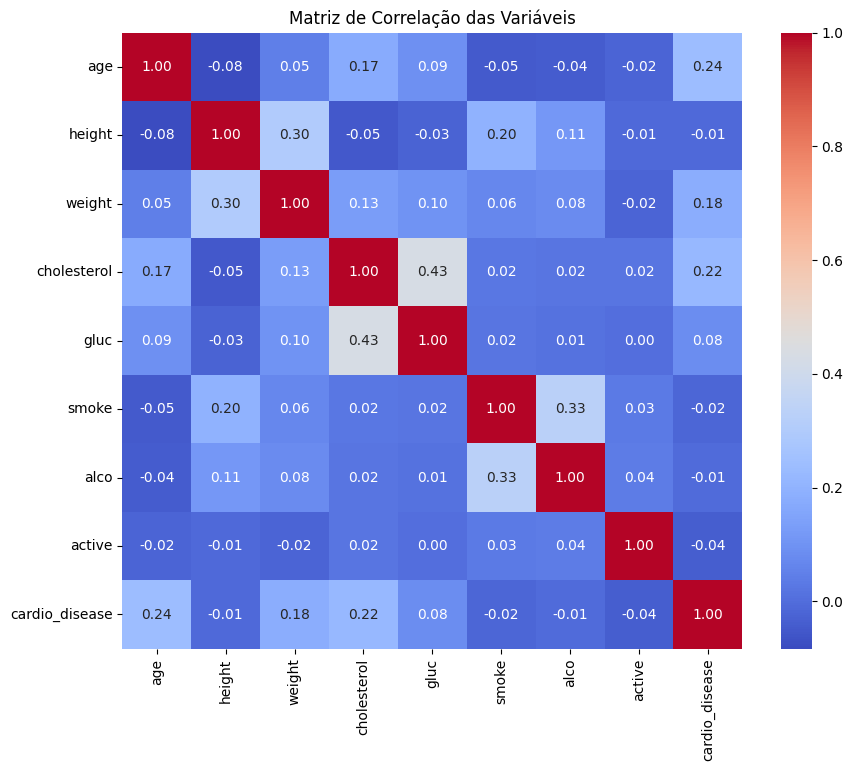

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correla√ß√£o das Vari√°veis")
plt.show()


# **Correla√ß√£o com cardio_disease**

Vari√°vel	Correla√ß√£o	Interpreta√ß√£o

**age	0.237**	Maior idade aumenta o risco de doen√ßa cardiovascular, o que faz sentido clinicamente.

**weight	0.183**	Pacientes mais pesados t√™m maior probabilidade de doen√ßa, indicando sobrepeso/obesidade como fator de risco.

**cholesterol	0.221**	Colesterol elevado est√° relacionado a maior chance de doen√ßa.

**gluc	0.083**	Glicose tem efeito positivo, mas fraco; pode indicar influ√™ncia menor na base analisada.

**height	-0.011**	Praticamente nenhuma rela√ß√£o. Altura n√£o afeta diretamente o risco.

**smoke	-0.019**	Pequena correla√ß√£o negativa, provavelmente pela baixa propor√ß√£o de fumantes na base.

**alco	-0.006** N√£o h√° rela√ß√£o significativa com a doen√ßa.

**active	-0.040**	Atividade f√≠sica tem efeito protetor fraco (mais ativo, menor risco).

**üí°Conclus√£o:**

Idade, peso e colesterol s√£o os fatores mais relevantes para prever doen√ßa cardiovascular na base.

Altura, √°lcool e tabagismo apresentam pouca correla√ß√£o, mas n√£o devem ser ignorados, pois podem interagir com outras vari√°veis.

---

# **Correla√ß√£o entre vari√°veis explicativas**
Vari√°veis	Correla√ß√£o	Interpreta√ß√£o

**weight x height	0.301**	Pessoas mais altas tendem a pesar mais, rela√ß√£o moderada.

**cholesterol x gluc	0.432**	Rela√ß√£o moderada entre glicose e colesterol ‚Äî pacientes com glicose mais alta tendem a ter colesterol mais alto.

**smoke x alco	0.331**	Pessoas que consomem √°lcool tamb√©m t√™m maior chance de fumar.

**Outras combina√ß√µes	<0.2**	Rela√ß√£o fraca ou quase inexistente.

**üí° Conclus√£o:**

N√£o h√° multicolinearidade severa (>0.9), ent√£o o modelo regress√£o log√≠stica n√£o deve ter problemas graves de sobreposi√ß√£o de vari√°veis.

Algumas rela√ß√µes moderadas s√£o interessantes: por exemplo, glicose e colesterol podem indicar perfil metab√≥lico de risco.

---

# **Observa√ß√µes gerais**

Idade, peso e colesterol s√£o os principais preditores da doen√ßa.

Atividade f√≠sica tem efeito protetor, mas fraco na base; pode ser relevante em combina√ß√£o com peso ou idade.

Tabagismo e √°lcool t√™m pouca influ√™ncia individualmente, possivelmente por baixa frequ√™ncia na amostra.

Rela√ß√µes moderadas (cholesterol x gluc, weight x height, smoke x alco) podem ajudar o modelo a capturar padr√µes de risco mais sutis.

# 4) Essa √© a sua √∫ltima etapa pr√© modelo. Voc√™ deve:

A) Separar a base em treino e teste.

B) Voc√™ considera que essa base precisa que os dados sejam padronizados? Se sim, porque? Se acredita que devem, ent√£o realize essa etapa.

C) Verifique se os dados est√£o balanceados, se n√£o, fa√ßa o balanceamento.


D) Visualize as bases de treino, teste (X E Y) e verifique se est√° tudo adequado.

In [18]:
# Remove a coluna categ√≥rica
base = base.drop(columns=['weight_group'])

# Conferindo novamente os tipos
print(base.dtypes)


age                 int64
gender              int64
height              int64
weight            float64
cholesterol         int64
gluc                int64
smoke               int64
alco                int64
active              int64
cardio_disease      int64
dtype: object


In [19]:
# Definir X e y
X = base.drop('cardio_disease', axis=1)  # todas as colunas menos o target
y = base['cardio_disease']              # target

# Separar em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Formato do X_train:", X_train.shape)
print("Formato do X_test:", X_test.shape)
print("Distribui√ß√£o do y_train:\n", y_train.value_counts(normalize=True))
print("Distribui√ß√£o do y_test:\n", y_test.value_counts(normalize=True))

Formato do X_train: (7977, 9)
Formato do X_test: (1995, 9)
Distribui√ß√£o do y_train:
 cardio_disease
1    0.503197
0    0.496803
Name: proportion, dtype: float64
Distribui√ß√£o do y_test:
 cardio_disease
1    0.503258
0    0.496742
Name: proportion, dtype: float64


**Passo B) Padroniza√ß√£o**

Temos vari√°veis em escalas muito diferentes:

age est√° na casa das dezenas (30‚Äì65)

height em cent√≠metros (150‚Äì200)

weight em quilos (40‚Äì120)

Outras como cholesterol, gluc, smoke, alco, active s√£o vari√°veis discretas (1, 2, 3 ou 0/1).

üëâ Modelos como regress√£o log√≠stica, KNN, SVM e redes neurais s√£o sens√≠veis √† escala dos dados.
Por isso, vale a pena padronizar para deixar tudo na mesma ordem de grandeza.

In [21]:
from sklearn.preprocessing import StandardScaler

# Criar scaler
scaler = StandardScaler()

# Ajustar apenas no treino e transformar ambos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


X_train_scaled shape: (7977, 9)
X_test_scaled shape: (1995, 9)


**C) Verifica√ß√£o do Balanceamento**

Distribui√ß√£o do target no treino:
cardio_disease
1    4014
0    3963
Name: count, dtype: int64

Distribui√ß√£o percentual no treino:
cardio_disease
1    0.503197
0    0.496803
Name: proportion, dtype: float64


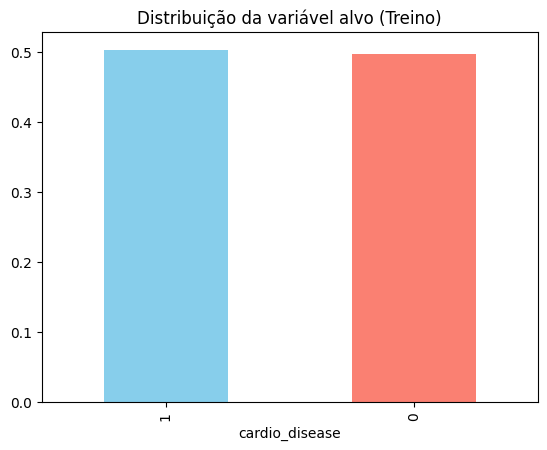

In [26]:
import matplotlib.pyplot as plt

print("Distribui√ß√£o do target no treino:")
print(y_train.value_counts())
print("\nDistribui√ß√£o percentual no treino:")
print(y_train.value_counts(normalize=True))

# Visualiza√ß√£o
y_train.value_counts(normalize=True).plot(
    kind='bar',
    color=['skyblue','salmon'],
    title="Distribui√ß√£o da vari√°vel alvo (Treino)"
)
plt.show()

A base est√° balanceada

**D) Verifica√ß√£o Treino/Teste**

In [27]:
print("X_train (scaled) - shape:", X_train_scaled.shape)
print("X_test (scaled) - shape:", X_test_scaled.shape)
print("y_train - shape:", y_train.shape)
print("y_test - shape:", y_test.shape)

print("\nPrimeiras linhas de X_train (antes de escalar):")
print(X_train.head())

print("\nPrimeiras linhas de y_train:")
print(y_train.head())


X_train (scaled) - shape: (7977, 9)
X_test (scaled) - shape: (1995, 9)
y_train - shape: (7977,)
y_test - shape: (1995,)

Primeiras linhas de X_train (antes de escalar):
      age  gender  height  weight  cholesterol  gluc  smoke  alco  active
2069   60       1     162    68.0            1     1      0     0       1
1250   52       1     160    84.0            1     1      0     0       0
1804   46       1     169    68.0            1     1      0     0       0
6874   64       1     158    66.0            3     1      0     0       1
5865   58       1     164    82.0            1     1      0     0       1

Primeiras linhas de y_train:
2069    1
1250    1
1804    0
6874    1
5865    1
Name: cardio_disease, dtype: int64


# 5) Realize a etapa de treinamento do modelo:

A) Fa√ßa o treinamento do modelo.

B) Traga o intercept e os coeficientes.

c) Avalie as m√©tricas do modelo treinado

D) Justifique se te parece que o modelo tem feito boas previs√µes ou n√£o.

In [53]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

In [54]:
# instanciando o modelo
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# treinando o modelo
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [55]:
# intercepto (bias)
intercept = log_reg.intercept_

# coeficientes de cada vari√°vel
coefficients = log_reg.coef_

print("Intercepto:", intercept)
print("Coeficientes:", coefficients)

Intercepto: [-4.51016713]
Coeficientes: [[ 0.06728705  0.0119783  -0.00928252  0.0266696   0.62427794 -0.13768943
  -0.15732702  0.02275286 -0.23933989]]


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# previs√µes
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# m√©tricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("Acur√°cia:", accuracy)
print("Precis√£o:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC-AUC:", roc_auc)
print("\nRelat√≥rio de Classifica√ß√£o:\n", classification_report(y_test, y_pred))
print("Matriz de Confus√£o:\n", confusion_matrix(y_test, y_pred))

Acur√°cia: 0.6280701754385964
Precis√£o: 0.6390658174097664
Recall: 0.599601593625498
F1-Score: 0.6187050359712231
ROC-AUC: 0.6754480564120913

Relat√≥rio de Classifica√ß√£o:
               precision    recall  f1-score   support

           0       0.62      0.66      0.64       991
           1       0.64      0.60      0.62      1004

    accuracy                           0.63      1995
   macro avg       0.63      0.63      0.63      1995
weighted avg       0.63      0.63      0.63      1995

Matriz de Confus√£o:
 [[651 340]
 [402 602]]


Ap√≥s avaliar o modelo de **regress√£o log√≠stica**, podemos concluir o seguinte:

* A acur√°cia de aproximadamente **63%** mostra que o modelo consegue acertar mais do que o acaso, mas ainda n√£o √© suficientemente forte para aplica√ß√µes cr√≠ticas.
* Os valores de **precis√£o (0.64)** e **recall (0.60)** indicam desempenho moderado. Embora a precis√£o seja razo√°vel, o recall mostra que o modelo **deixa de identificar cerca de 40% dos casos de doen√ßa**.
* A m√©trica **ROC-AUC (0.67)** refor√ßa que a separa√ß√£o entre as classes existe, mas n√£o √© robusta.
* A matriz de confus√£o confirma que o principal problema do modelo s√£o os **falsos negativos**, ou seja, pessoas que realmente possuem a doen√ßa mas que o modelo n√£o conseguiu prever.

üìå **Justificativa final:**
O modelo apresenta uma performance apenas razo√°vel. Ele captura alguns padr√µes, mas n√£o pode ser considerado confi√°vel para aplica√ß√£o em cen√°rios reais de diagn√≥stico m√©dico, j√° que falha em identificar uma quantidade significativa de casos de doen√ßa. Portanto, seria recomend√°vel explorar outras t√©cnicas de machine learning (como Random Forest ou XGBoost), ajustar o limiar de decis√£o e criar novas vari√°veis (ex.: IMC, faixas de idade, intera√ß√µes entre colesterol e glicose) para melhorar as previs√µes.

# 6) Teste seu modelo!

A) Aplique o modelo aos dados de teste.

B) Avalie as m√©tricas do modelo treinado

C) Plote o gr√°fico da curva AUC-ROC e explique o que consegue analisar atrav√©s do gr√°fico.

In [59]:
y_test_pred = log_reg.predict(X_test_scaled_df)
y_test_proba = log_reg.predict_proba(X_test_scaled_df)[:, 1]

In [60]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

print(classification_report(y_test, y_test_pred, zero_division=0))
print("Matriz de Confus√£o:\n", confusion_matrix(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))

              precision    recall  f1-score   support

           0       0.50      1.00      0.66       991
           1       0.00      0.00      0.00      1004

    accuracy                           0.50      1995
   macro avg       0.25      0.50      0.33      1995
weighted avg       0.25      0.50      0.33      1995

Matriz de Confus√£o:
 [[ 991    0]
 [1004    0]]
ROC-AUC: 0.63160023880261


ROC-AUC: 0.63160023880261


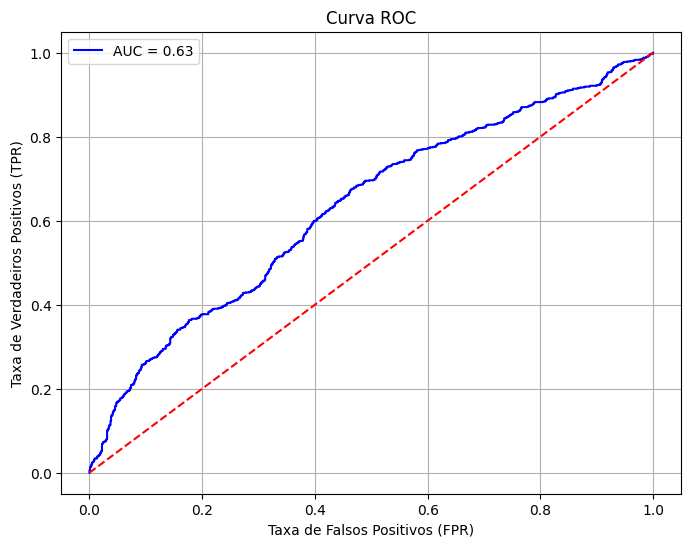

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcular False Positive Rate, True Positive Rate e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_test_proba)
print("ROC-AUC:", auc_score)

# Plotar curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0,1],[0,1],'--', color='red')  # Linha de refer√™ncia (random)
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

**Como interpretar o gr√°fico:**

**Linha azul** ‚Üí mostra o desempenho do modelo. Quanto mais pr√≥ximo do canto superior esquerdo, melhor.

**Linha vermelha pontilhada** ‚Üí representa uma previs√£o aleat√≥ria (AUC = 0.5).

**AUC**(Area Under Curve) ‚Üí mede a capacidade do modelo de separar as classes:

0.5 ‚Üí aleat√≥rio

0.6‚Äì0.7 ‚Üí fraco

0.7‚Äì0.8 ‚Üí razo√°vel

0.8‚Äì0.9 ‚Üí bom

0.9+ ‚Üí excelente

No meu caso, com ROC-AUC ~0.63, significa que o modelo tem uma capacidade limitada, mas ainda consegue diferenciar um pouco entre pacientes com e sem doen√ßas cardiovasculares.

# 7) Explique:

A) Explique com suas palavras regress√£o logistica.

B) Explique porque a regress√£o logistica √© um modelo de classifica√ß√£o.

C) Explique quais pontos em comum a regress√£o logistica tem da regress√£o linear.



**A) O que √© Regress√£o Log√≠stica?**

A regress√£o log√≠stica √© um tipo de modelo que usamos para prever se algo vai acontecer ou n√£o, ou seja, se pertence a uma categoria ou outra.
No nosso caso, ela ajuda a prever se uma pessoa tem ou n√£o risco de doen√ßa cardiovascular, com base nas informa√ß√µes dela (idade, peso, altura, colesterol, etc).

O que acontece √© que o modelo calcula uma probabilidade de um evento acontecer (por exemplo, ter a doen√ßa). Se a probabilidade for alta, o modelo diz ‚Äúsim‚Äù, se for baixa, diz ‚Äún√£o‚Äù.

---

**B) Por que a regress√£o log√≠stica √© um modelo de classifica√ß√£o?**

Ela √© de classifica√ß√£o porque, diferente da regress√£o linear que prev√™ valores cont√≠nuos (tipo quanto algu√©m vai ganhar, ou a temperatura), a regress√£o log√≠stica classifica os dados em categorias.

No nosso projeto, temos duas categorias:

1 ‚Üí paciente com doen√ßa cardiovascular

0 ‚Üí paciente sem doen√ßa cardiovascular

O modelo decide em qual dessas categorias cada paciente se encaixa, usando a probabilidade que ele calcula.

---

**C) Pontos em comum com a regress√£o linear**

Apesar de ser de classifica√ß√£o, a regress√£o log√≠stica tem v√°rias coisas parecidas com a regress√£o linear:

Usa uma equa√ß√£o linear: mesmo que o resultado final seja uma probabilidade, o modelo combina os dados de forma linear (como peso * coeficiente + idade * coeficiente + ...).

Coeficientes indicam for√ßa e dire√ß√£o: os n√∫meros que o modelo calcula para cada vari√°vel mostram como cada caracter√≠stica influencia a previs√£o. Por exemplo, quanto maior o colesterol, maior a chance de doen√ßa.

Treinamento parecido: o modelo ajusta os coeficientes para minimizar o erro entre as previs√µes e os resultados reais, assim como a regress√£o linear.